In [2]:
#library
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

from plotly.subplots import make_subplots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf




import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from scipy.stats import kurtosis, skew
        

In [3]:
#read data
info = pd.read_csv("../g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("../g-research-crypto-forecasting/train.csv")

# Feature description

In [4]:
ctrain.head()

timestamp  Asset_ID  Count        Open        High         Low  \
0  1514764860         2   40.0   2376.5800   2399.5000   2357.1400   
1  1514764860         0    5.0      8.5300      8.5300      8.5300   
2  1514764860         1  229.0  13835.1940  14013.8000  13666.1100   
3  1514764860         5   32.0      7.6596      7.6596      7.6567   
4  1514764860         7    5.0     25.9200     25.9200     25.8740   

        Close       Volume          VWAP    Target  
0   2374.5900    19.233005   2373.116392 -0.004218  
1      8.5300    78.380000      8.530000 -0.014399  
2  13850.1760    31.550062  13827.062093 -0.014643  
3      7.6576  6626.713370      7.657713 -0.013922  
4     25.8770   121.087310     25.891363 -0.008264

The feature descriptions:
*   **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
*   **Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. `Asset_ID = 1` for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
*   **Count**: Total number of trades in the time interval (last minute).
*   **Open**:	Opening price of the time interval (in USD).
*   **High**:	Highest price reached during time interval (in USD).
*   **Low**: Lowest price reached during time interval (in USD).
*   **Close**:	Closing price of the time interval (in USD).
*   **Volume**:	Quantity of asset bought or sold, displayed in base currency USD.
*   **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
*   **Target**: Residual log-returns for the asset over a 15 minute horizon. The formula is provided in the report.

Look at the asset names

In [5]:
info.Asset_Name.unique()


array(['Bitcoin Cash', 'Binance Coin', 'Bitcoin', 'EOS.IO',
       'Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON',
       'Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin'], dtype=object)

In [6]:
#time frame that we have
pd.to_datetime(ctrain['timestamp'], unit='s')

0          2018-01-01 00:01:00
1          2018-01-01 00:01:00
2          2018-01-01 00:01:00
3          2018-01-01 00:01:00
4          2018-01-01 00:01:00
                   ...        
24236801   2021-09-21 00:00:00
24236802   2021-09-21 00:00:00
24236803   2021-09-21 00:00:00
24236804   2021-09-21 00:00:00
24236805   2021-09-21 00:00:00
Name: timestamp, Length: 24236806, dtype: datetime64[ns]

# Candlestick charts

In [7]:
#Dictionary for assets
rename_dict = {}
asset_details = info 
for a in asset_details['Asset_ID']:
    rename_dict[a] = asset_details[asset_details.Asset_ID == a].Asset_Name.values[0]

display(rename_dict)


{2: 'Bitcoin Cash',
 0: 'Binance Coin',
 1: 'Bitcoin',
 5: 'EOS.IO',
 7: 'Ethereum Classic',
 6: 'Ethereum',
 9: 'Litecoin',
 11: 'Monero',
 13: 'TRON',
 12: 'Stellar',
 3: 'Cardano',
 8: 'IOTA',
 10: 'Maker',
 4: 'Dogecoin'}

In [8]:
# Impute Missing Time Value

def c_time_sub(asset_id, data=ctrain):
    df=data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    df.index = pd.to_datetime(df.index, unit='s')
    return df


#  Bitcoin
btc=c_time_sub(asset_id=1)

#  Ethereum
eth=c_time_sub(asset_id=6)

#  Cardano
ada=c_time_sub(asset_id=3)

In [9]:
#candlestick

def c_chart(data,label):
    candlestick = go.Figure(data = [go.Candlestick(x =data.index,
                                               open = data[('Open')],
                                               high = data[('High')],
                                               low = data[('Low')],
                                               close = data[('Close')])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
        'text': '{:} Candelstick Chart'.format(label),
        "y":0.8,
        "x":0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

%matplotlib inline
btc_candle=c_chart(btc[-90:], label="BTC Price")
btc_candle.show()

eth_candle=c_chart(eth[-90:], label="ETH Price ")
eth_candle.show()


# Training Data Distribution among different Assets

In [10]:
data = ctrain

asset_count= []
for i in range(14):
    count = (data["Asset_ID"]==i).sum()
    asset_count.append(count)
fig = px.bar(x = asset_details.sort_values("Asset_ID")["Asset_Name"],
             y = asset_count , 
             color = asset_count ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Assets")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()


# Statistics for BTC for Close and logreturns of Close

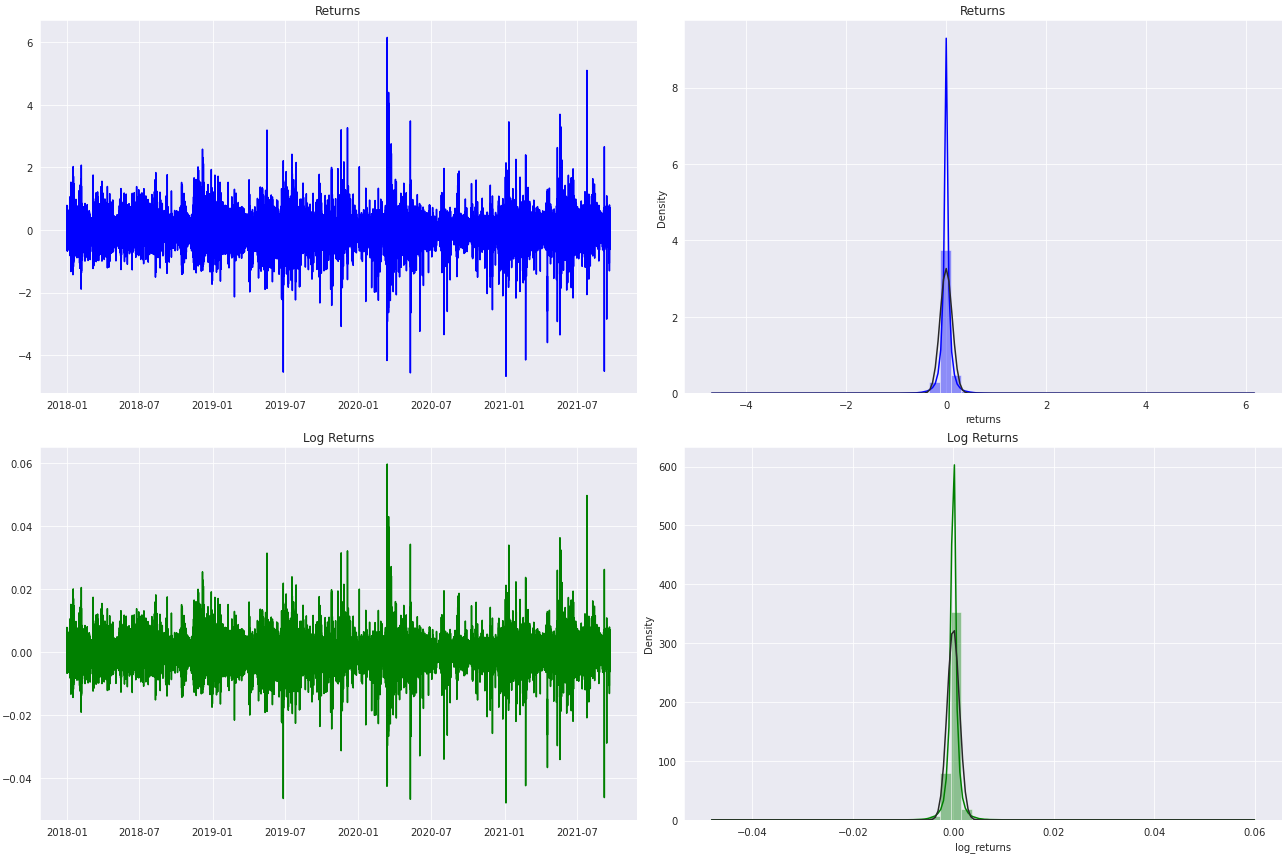

In [11]:
btc['returns'] = 100 * btc.Close.pct_change().dropna()

btc['log_returns'] = np.log(btc.Close/btc.Close.shift(1))
btc.dropna(inplace=True)

# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
df = btc.copy()
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()

    fig.show();



In [12]:
#returns
print( 'returns: excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(df.returns) ))
print( 'returns: skewness of normal distribution (should be 0): {}'.format( skew(df.returns) ))

#log_returns
print( 'log_returns: excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(df.log_returns) ))
print( 'log_returns: skewness of normal distribution (should be 0): {}'.format( skew(df.log_returns) ))

returns: excess kurtosis of normal distribution (should be 0): 57.42727635842122
returns: skewness of normal distribution (should be 0): 0.07662449781920444
log_returns: excess kurtosis of normal distribution (should be 0): 56.762175287575666
log_returns: skewness of normal distribution (should be 0): -0.03150487455126551


- skewness:
returns - positive, log_returns - negative

- positive kurtosis (leptokurtic) - Both Returns & Log Returns show higher peak with thicker tails than the standard normal distribution.

# Cryptocurrency Log Return Correlation Plot for 2021


Bitcoin Cash
Binance Coin
Bitcoin
EOS.IO
Ethereum Classic
Ethereum
Litecoin
Monero
TRON
Stellar
Cardano
IOTA
Maker
Dogecoin


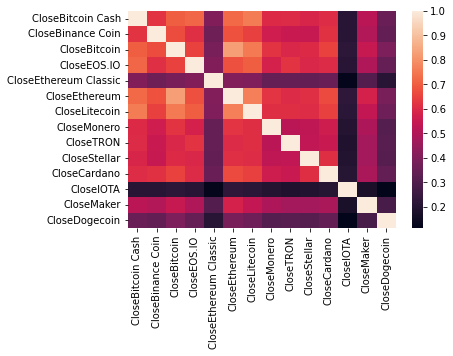

In [13]:
import time

# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)
def plot_corr_2021(ctrain, info):
    # auxiliary function, from datetime to timestamp
    totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))
    # create dataframe with returns for all assets
    
    crypto_df = ctrain
    all_assets_2021 = pd.DataFrame([])
    
    for asset_id, asset_name in rename_dict.items():
        print(asset_name)
        asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
        asset = asset.loc[totimestamp('01/01/2021'):]
        asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
        lret = log_return(asset.Close.fillna(0))[1:]
        
        all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")
    all_assets_2021.rename(columns = {'Close':'CloseBitcoin Cash'}, inplace=True)
    sns.heatmap(all_assets_2021.corr());
    """plt.imshow(all_assets_2021.corr());
    plt.yticks(info.Asset_ID.values, info.Asset_Name.values);
    plt.xticks(info.Asset_ID.values, info.Asset_Name.values, rotation='vertical');
    plt.colorbar();
    plt.savefig('corr.jpg')"""
    all_assets_2021_corr =  all_assets_2021.corr()
    """all_assets_2021_corr.columns = info.Asset_Name.values
    all_assets_2021_corr.index = info.Asset_Name.values"""
    return all_assets_2021, all_assets_2021_corr
all_assets_2021, all_assets_2021_corr = plot_corr_2021(ctrain, info)


In [15]:
#the top correlation
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, ascending=False):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=ascending)
    return au_corr[0:n]
pd.DataFrame(get_top_abs_correlations(all_assets_2021_corr, n=10, ascending=False), columns=['Correlation'])


Correlation
CloseBitcoin      CloseEthereum     0.935583
CloseEthereum     CloseLitecoin     0.877506
CloseBitcoin Cash CloseLitecoin     0.871912
CloseBitcoin      CloseLitecoin     0.865092
CloseBitcoin Cash CloseEOS.IO       0.820849
                  CloseEthereum     0.818637
CloseEOS.IO       CloseLitecoin     0.795675
CloseBitcoin Cash CloseBitcoin      0.793878
CloseBinance Coin CloseEthereum     0.753721
CloseEOS.IO       CloseEthereum     0.746704

In [16]:
#least correlated
pd.DataFrame(get_top_abs_correlations(all_assets_2021_corr, n=10, ascending=True), columns=['Correlation'])



Correlation
CloseEthereum         CloseDogecoin             0.000577
CloseEthereum Classic CloseCardano              0.001252
                      CloseMonero               0.003734
                      CloseStellar              0.008954
                      CloseTRON                 0.011784
CloseBinance Coin     CloseEthereum Classic     0.020047
CloseLitecoin         CloseDogecoin             0.026410
CloseBitcoin          CloseEthereum Classic     0.032001
                      CloseDogecoin             0.034648
CloseBitcoin Cash     CloseDogecoin             0.042942

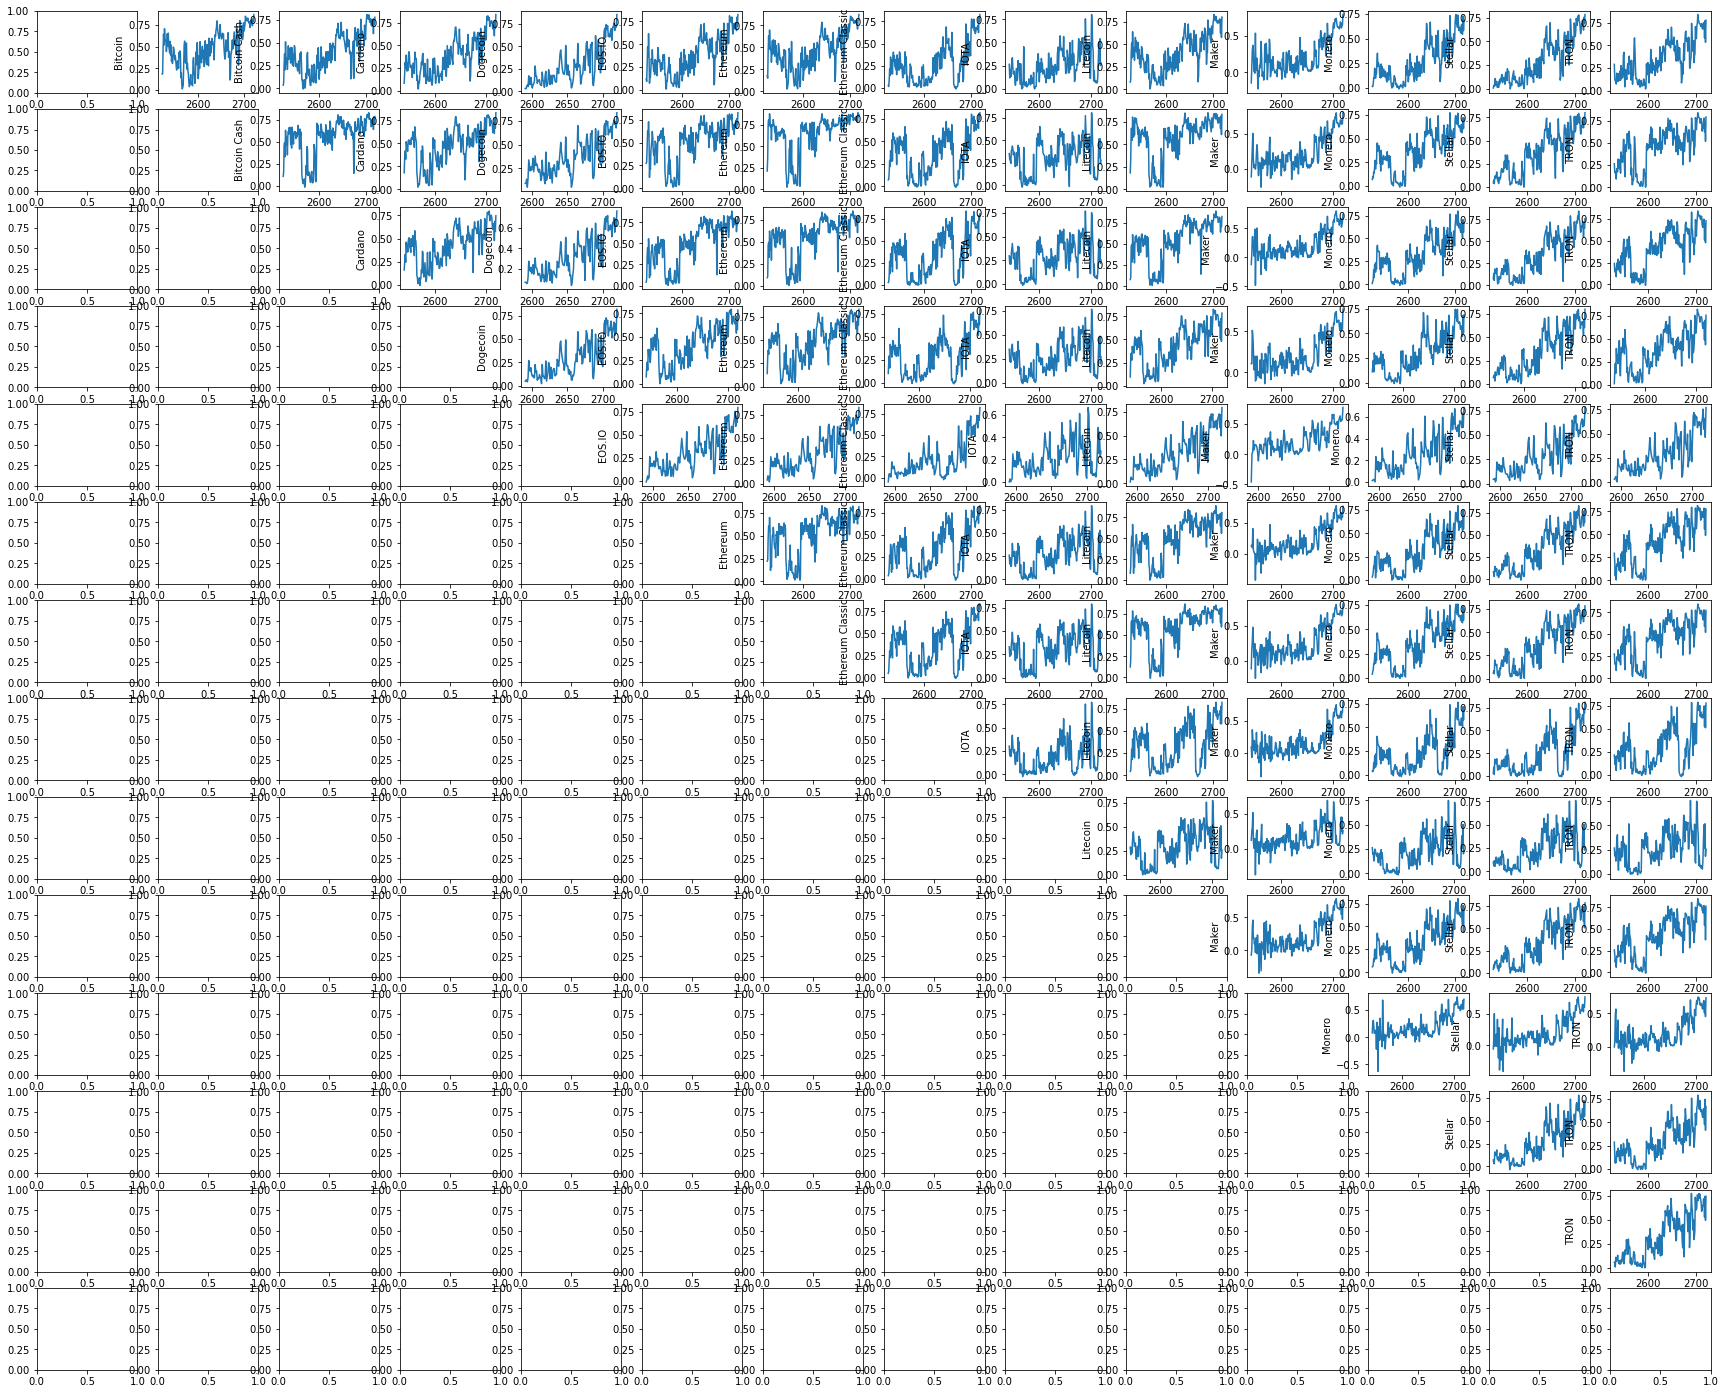

In [17]:
#correlations over time
# join two asset in single DataFrame
def corr_over_time(crypto_df, asset_id_1 =1, asset_id_2 = 6):
    btc = crypto_df[crypto_df["Asset_ID"]==asset_id_1].set_index("timestamp")
    eth= crypto_df[crypto_df["Asset_ID"]==asset_id_2].set_index("timestamp")

    lret_btc_long = log_return(btc.Close)[1:]
    lret_eth_long = log_return(eth.Close)[1:]
    lret_btc_long.rename('lret_btc', inplace=True)
    lret_eth_long.rename('lret_eth', inplace=True)
    two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

    # group consecutive rows and use .corr() for correlation between columns
    corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]
    return corr_time

    #corr_time.plot();
    """plt.xticks([])
    plt.ylabel("Correlation")
    plt.title("Correlation between BTC and ETH over time");"""

fig, ax = plt.subplots(nrows=14, ncols=14, figsize=(30, 25))
for i in range(0,13):
    for j in range(i+1,14):
        g = sns.lineplot(data = corr_over_time(ctrain,asset_id_1 =i, asset_id_2 = j),ax=ax[i,j])
        g.set(xlabel=rename_dict[i], ylabel=rename_dict[j])

We can see that the correlations between assets change over time.

Additionally, candlestick charts for all assets,
the illustration of BTC and ETH prices groupped by year could be seen here: https://www.kaggle.com/iamleonie/to-the-moon-g-research-crypto-forecasting-eda#Data-Overview
It again proves that correlation between coins is changing.

# Closing Price for BTC, ETH, ADA





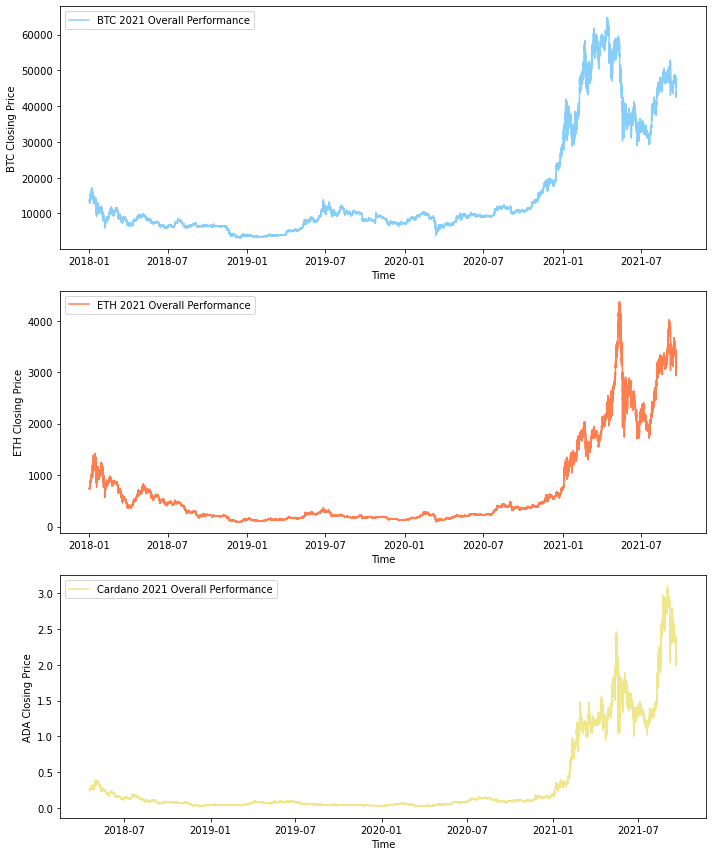

In [18]:
# Plot the Closing Price for BTC, ETH, ADA (Cardano)
f= plt.figure(figsize=(10,12))  

def gplot(no , data, price, label, ylabel, color):
    ax=f.add_subplot(no)
    plt.plot(data[price], label=label, color=color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    return plt

gplot(no=311, data=btc, price="Close" , label="BTC 2021 Overall Performance", ylabel="BTC Closing Price", color="Lightskyblue")
gplot(no=312, data=eth, price="Close" ,label="ETH 2021 Overall Performance", ylabel="ETH Closing Price", color="Coral")
gplot(no=313, data=ada, price="Close" ,label="Cardano 2021 Overall Performance", ylabel="ADA Closing Price", color="khaki")

plt.tight_layout()
plt.show()

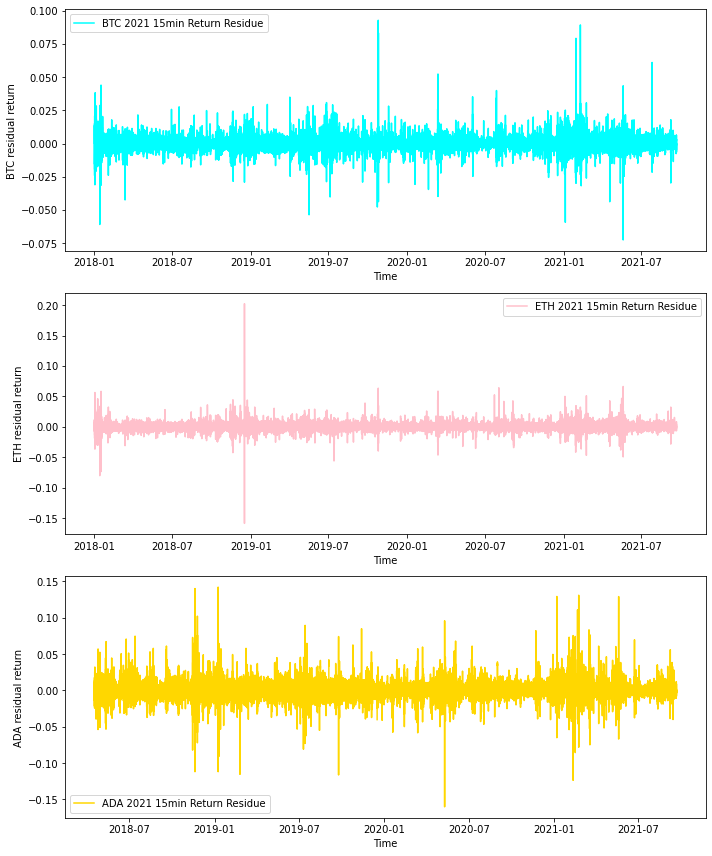

In [19]:
#Target : 15 minute resudualized returns
#Residual Return: An asset's residual return equals its excess return minus beta times the benchmark excess return.

f= plt.figure(figsize=(10,12))  
gplot(no=311, data=btc, price="Target" , label="BTC 2021 15min Return Residue", ylabel="BTC residual return", color="Aqua")
gplot(no=312, data=eth, price="Target" ,label="ETH 2021 15min Return Residue", ylabel="ETH residual return", color="Pink")
gplot(no=313, data=ada, price="Target" ,label="ADA 2021 15min Return Residue", ylabel="ADA residual return", color="gold")


plt.tight_layout()
plt.show()

As we can see ETH, and BTC residual return are relatively stable compared to ADA. This might be a good implication that if the investor would take short time trading opportunities, ADA is a better choice.

If the investor is risk averse, BTC or ETH will be a better fit


# Technical Analysis charts
Across the industry, there are hundreds of patterns and signals that have been developed by researchers to support technical analysis trading, it would be a bit tedious to code them. 
Fortunately there is a technical analysis library in python available(created by <a href="https://github.com/bukosabino" >bukosabino</a>), the library has implemented 42 indicators:


<b>Volume:</b>
<ul>
<li>Money Flow Index (MFI)</li>
<li>Accumulation/Distribution Index (ADI)</li>
<li>On-Balance Volume (OBV)</li>
<li>Chaikin Money Flow (CMF)</li>
<li>Force Index (FI)</li>
<li>Ease of Movement (EoM, EMV)</li>
<li>Volume-price Trend (VPT)</li>
<li>Negative Volume Index (NVI)</li>
<li>Volume Weighted Average Price (VWAP)</li>
</ul>
<b>Volatility:</b>
<ul>
<li>Average True Range (ATR)</li>
<li>Bollinger Bands (BB)</li>
<li>Keltner Channel (KC)</li>
<li>Donchian Channel (DC)</li>
<li>Ulcer Index (UI)</li>
</ul>

<b>Trend:</b>
<ul>
<li>Simple Moving Average (SMA)</li>
<li>Exponential Moving Average (EMA)</li>
<li>Weighted Moving Average (WMA)</li>
<li>Moving Average Convergence Divergence (MACD)</li>
<li>Average Directional Movement Index (ADX)</li>
<li>Vortex Indicator (VI)</li>
<li>Trix (TRIX)</li>
<li>Mass Index (MI)</li>
<li>Commodity Channel Index (CCI)</li>
<li>Detrended Price Oscillator (DPO)</li>
<li>KST Oscillator (KST)</li>
<li>Ichimoku Kinkō Hyō (Ichimoku)</li>
<li>Parabolic Stop And Reverse (Parabolic SAR)</li>
<li>Schaff Trend Cycle (STC)</li>
</ul>

<b>Momentum:</b>
<ul>
<li>Relative Strength Index (RSI)</li>
<li>Stochastic RSI (SRSI)</li>
<li>True strength index (TSI)</li>
<li>Ultimate Oscillator (UO)</li>
<li>Stochastic Oscillator (SR)</li>
<li>Williams %R (WR)</li>
<li>Awesome Oscillator (AO)</li>
<li>Kaufman's Adaptive Moving Average (KAMA)</li>
<li>Rate of Change (ROC)</li>
<li>Percentage Price Oscillator (PPO)</li>
<li>Percentage Volume Oscillator (PVO)</li>
</ul>
<b>Others:</b>
<ul>
<li>Daily Return (DR)</li>
<li>Daily Log Return (DLR)</li>
<li>Cumulative Return (CR)</li>
</ul>



<b>Documentation:</b>
<ul>
    <li><a href = "https://technical-analysis-library-in-python.readthedocs.io/en/latest/">Technical Analysis library documentation</a></li>
</ul>
</div>



# Moving average


In [20]:

def mov_avg(df, a = 'W',Asset_ID =1, N = 10):
    
    df = df[df.Asset_ID == Asset_ID]
    
    df.set_index(df['timestamp'], inplace=True)
    df.drop('timestamp', axis=1, inplace=True)
    df.index = pd.to_datetime(df.index, unit='s')

    #weekly
    convertion={
        'Open':'first',
        'High':'max',
        'Low':'min',
        'Close':'mean',
        'Volume':'sum',    
    }
    ds_df = df.resample(a).apply(convertion)
    #avg # of mins in a week

    
    
    #Simple ma
    ds_df['rolling_mean' + str(a) + '_' + str(5)] = ds_df.Close.rolling(window=5).mean()
    ds_df['rolling_mean' + str(a) + '_' + str(10)] = ds_df.Close.rolling(window=10).mean()
    fig = go.Figure(go.Candlestick(x=ds_df.index,open=ds_df['Open'],high=ds_df['High'],low=ds_df['Low'],close=ds_df['Close']))
    fig.update_layout(title='SMA '+str(rename_dict[Asset_ID])+' Close', yaxis_title=str(rename_dict[Asset_ID]))
    fig.update_yaxes(type="log")
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['Close'],mode='lines',name='Close'))
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['rolling_mean' + str(a) + '_' + str(5)], mode='lines', name='SMA MEAN of 5 ' + str(a),line=dict(color='royalblue', width=2)))
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['rolling_mean' + str(a) + '_' + str(10)], mode='lines', name='SMA MEAN of 10 ' + str(a), line=dict(color='#555555', width=2)))
    fig.show()
    
    
    #Exp ma
    ewma = pd.Series.ewm
    ds_df['rolling_ema_'+ str(N)]  = ds_df.Close.ewm(min_periods=N, span=N).mean()
    fig = go.Figure(go.Candlestick(x=ds_df.index,open=ds_df['Open'],high=ds_df['High'],low=ds_df['Low'],close=ds_df['Close']))
    fig.update_layout(title='EMA ' +str(rename_dict[Asset_ID])+' Close', yaxis_title=str(rename_dict[Asset_ID]))
    fig.update_yaxes(type="log")
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['Close'],mode='lines',name='Close'))
    fig.add_trace(go.Scatter(x=ds_df.index, y=ds_df['rolling_ema_' + str(N)], mode='lines', name='EMA MEAN span of '+str(N)+' rolled by '+ str(a),line=dict(color='royalblue', width=2)))
    fig.show()
mov_avg(ctrain, Asset_ID =1 )


In [21]:
#ETH
mov_avg(ctrain, Asset_ID =6 )

Other technical analysis could be found here https://www.kaggle.com/shakshyathedetector/crypto-prediction-technical-analysis-features#Moving-average
There are:
- Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of prices. The MACD is calculated by subtracting the 26-day exponential moving average (EMA) from the 12-day EMA
- Bollinger Bands are a type of statistical chart characterizing the prices and volatility over time of a financial instrument or commodity, using a formulaic method propounded by John Bollinger in the 1980s. Financial traders employ these charts as a methodical tool to inform trading decisions, control automated trading systems, or as a component of technical analysis. Bollinger Bands display a graphical band (the envelope maximum and minimum of moving averages, similar to Keltner or Donchian channels) and volatility (expressed by the width of the envelope) in one two-dimensional chart.
- A Volume Moving Average is the simplest volume-based technical indicator. Similar to a price moving average, a VMA is an average volume of a security (stock), commodity, index or exchange over a selected period of time. Volume Moving Averages are used in charts and in technical analysis to smooth and describe a volume trend by filtering short term spikes and gaps.




##Statistical analysis

In [22]:
import time


def logret_all_assets(ctrain, info):
    # auxiliary function, from datetime to timestamp
    totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))
    # create dataframe with returns for all assets
    
    crypto_df = ctrain
    all_assets_2021 = pd.DataFrame([])
    
    for asset_id, asset_name in rename_dict.items():
        #print(asset_name)
        asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
        #asset = asset.loc[totimestamp('01/01/2021'):]
        asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
        lret = log_return(asset.Close.fillna(0))[1:]
        
        all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")
    all_assets_2021.rename(columns = {'Close':'Close Bitcoin Cash'}, inplace=True)
    all_assets_2021.index  = pd.to_datetime(all_assets_2021.index, unit='s')
    return all_assets_2021
all_assets = logret_all_assets(ctrain, info)

In [23]:
#logret of all assets
all_assets.head()

Close Bitcoin Cash  CloseBinance Coin  CloseBitcoin  \
timestamp                                                                  
2018-01-01 00:02:00           -0.000970          -0.001819     -0.001595   
2018-01-01 00:03:00           -0.000094          -0.003494     -0.001939   
2018-01-01 00:04:00           -0.000631           0.001896     -0.002414   
2018-01-01 00:05:00           -0.000166          -0.005296     -0.003137   
2018-01-01 00:06:00           -0.001134          -0.006645     -0.000569   

                     CloseEOS.IO  CloseEthereum Classic  CloseEthereum  \
timestamp                                                                
2018-01-01 00:02:00    -0.000118               0.000773      -0.000335   
2018-01-01 00:03:00    -0.000719               0.021866      -0.001027   
2018-01-01 00:04:00    -0.002015              -0.000756      -0.000543   
2018-01-01 00:05:00    -0.003385              -0.000473      -0.001898   
2018-01-01 00:06:00    -0.005006              -0.001401      -0.000687   

                     CloseLitecoin  CloseMonero  CloseTRON  CloseStellar  \
timestamp                                                                  
2018-01-01 00:02:00      -0.001555    -0.000030        NaN           NaN   
2018-01-01 00:03:00       0.005072    -0.000790        NaN           NaN   
2018-01-01 00:04:00      -0.007662    -0.003134        NaN           NaN   
2018-01-01 00:05:00      -0.002031    -0.002227        NaN           NaN   
2018-01-01 00:06:00      -0.003099     0.013680        NaN           NaN   

                     CloseCardano  CloseIOTA  CloseMaker  CloseDogecoin  
timestamp                                                                
2018-01-01 00:02:00           NaN        NaN         NaN            NaN  
2018-01-01 00:03:00           NaN        NaN         NaN            NaN  
2018-01-01 00:04:00           NaN        NaN         NaN            NaN  
2018-01-01 00:05:00           NaN        NaN         NaN            NaN  
2018-01-01 00:06:00           NaN        NaN         NaN            NaN

In [24]:
#all_assets.to_csv('logret_all_years_assets.csv')

<AxesSubplot:>

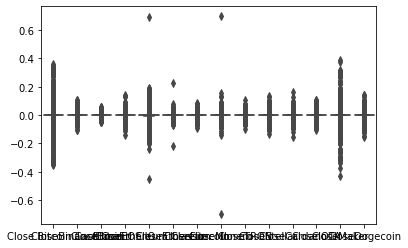

In [25]:
sns.boxplot(data = all_assets)

In [26]:
stat = all_assets.describe()

In [27]:
stat

Close Bitcoin Cash  CloseBinance Coin  CloseBitcoin   CloseEOS.IO  \
count        1.956959e+06       1.956959e+06  1.956959e+06  1.956959e+06   
mean        -7.558041e-07       1.917719e-06  5.789393e-07 -3.074305e-07   
std          5.008949e-03       1.806579e-03  1.221378e-03  2.422947e-03   
min         -3.502645e-01      -1.074153e-01 -4.789219e-02 -1.426787e-01   
25%         -6.204200e-04      -6.185577e-04 -3.609924e-04 -6.405195e-04   
50%          0.000000e+00       0.000000e+00  1.820329e-06  0.000000e+00   
75%          6.149605e-04       6.433299e-04  3.653205e-04  6.392231e-04   
max          3.597722e-01       1.065439e-01  5.974073e-02  1.392123e-01   

       CloseEthereum Classic  CloseEthereum  CloseLitecoin   CloseMonero  \
count           1.956959e+06   1.956959e+06   1.956959e+06  1.956959e+06   
mean            3.269642e-07   7.115949e-07  -1.845365e-07 -1.786102e-07   
std             7.098978e-03   1.636635e-03   2.090472e-03  3.588423e-03   
min            -4.495042e-01  -2.177505e-01  -9.086151e-02 -6.979686e-01   
25%            -8.973867e-04  -5.229336e-04  -6.352619e-04 -6.272139e-04   
50%             0.000000e+00   3.338402e-06   0.000000e+00  0.000000e+00   
75%             8.972688e-04   5.324643e-04   6.355277e-04  6.318182e-04   
max             6.924528e-01   2.264079e-01   8.494769e-02  6.972494e-01   

          CloseTRON  CloseStellar  CloseCardano     CloseIOTA    CloseMaker  \
count  1.903823e+06  1.889287e+06  1.803769e+06  1.772153e+06  1.770279e+06   
mean   4.782726e-07 -1.291586e-07  1.152636e-06 -3.204244e-07  4.077770e-07   
std    2.293306e-03  2.492224e-03  1.947571e-03  4.580578e-03  2.825617e-03   
min   -9.832049e-02 -1.318202e-01 -1.516933e-01 -1.057464e-01 -4.297375e-01   
25%   -5.611751e-04 -6.196548e-04 -6.387104e-04 -7.572889e-04  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    5.663635e-04  6.273772e-04  6.417799e-04  7.804574e-04  0.000000e+00   
max    1.069536e-01  1.365755e-01  1.596909e-01  1.057464e-01  3.861363e-01   

       CloseDogecoin  
count   1.285046e+06  
mean    3.360425e-06  
std     2.429896e-03  
min    -1.556270e-01  
25%    -6.018154e-04  
50%     0.000000e+00  
75%     6.012228e-04  
max     1.432908e-01

In [28]:
stat.loc['mean',:].sort_values()

Close Bitcoin Cash      -7.558041e-07
CloseIOTA               -3.204244e-07
CloseEOS.IO             -3.074305e-07
CloseLitecoin           -1.845365e-07
CloseMonero             -1.786102e-07
CloseStellar            -1.291586e-07
CloseEthereum Classic    3.269642e-07
CloseMaker               4.077770e-07
CloseTRON                4.782726e-07
CloseBitcoin             5.789393e-07
CloseEthereum            7.115949e-07
CloseCardano             1.152636e-06
CloseBinance Coin        1.917719e-06
CloseDogecoin            3.360425e-06
Name: mean, dtype: float64

Taking into accout the given dataframe, Bitcoin Cash Close return has the lowest mean (the highest loss) while Dogecoin - the highest gain

In [29]:


stat.loc['std',:].sort_values()

CloseBitcoin             0.001221
CloseEthereum            0.001637
CloseBinance Coin        0.001807
CloseCardano             0.001948
CloseLitecoin            0.002090
CloseTRON                0.002293
CloseEOS.IO              0.002423
CloseDogecoin            0.002430
CloseStellar             0.002492
CloseMaker               0.002826
CloseMonero              0.003588
CloseIOTA                0.004581
Close Bitcoin Cash       0.005009
CloseEthereum Classic    0.007099
Name: std, dtype: float64

Bitcoin is the least volatile, Ethereum Classic - the most



## 2021 year

<AxesSubplot:>

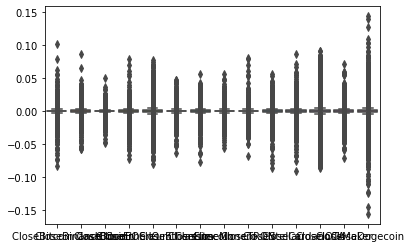

In [30]:
sns.boxplot(data = all_assets_2021)

In [31]:
stat_2021 = all_assets_2021.describe()

In [32]:
stat_2021.loc['mean',:].sort_values()

CloseLitecoin            6.113479e-07
CloseBitcoin             1.033427e-06
CloseMonero              1.049478e-06
CloseBitcoin Cash        1.193749e-06
CloseEOS.IO              1.268248e-06
CloseStellar             2.116505e-06
CloseTRON                3.248757e-06
CloseEthereum            3.672655e-06
CloseMaker               3.767812e-06
CloseIOTA                3.878115e-06
CloseEthereum Classic    5.704323e-06
CloseBinance Coin        6.022143e-06
CloseCardano             6.470575e-06
CloseDogecoin            1.002567e-05
Name: mean, dtype: float64

Litecoin has the lowest return, Dodgecoin-the greatest

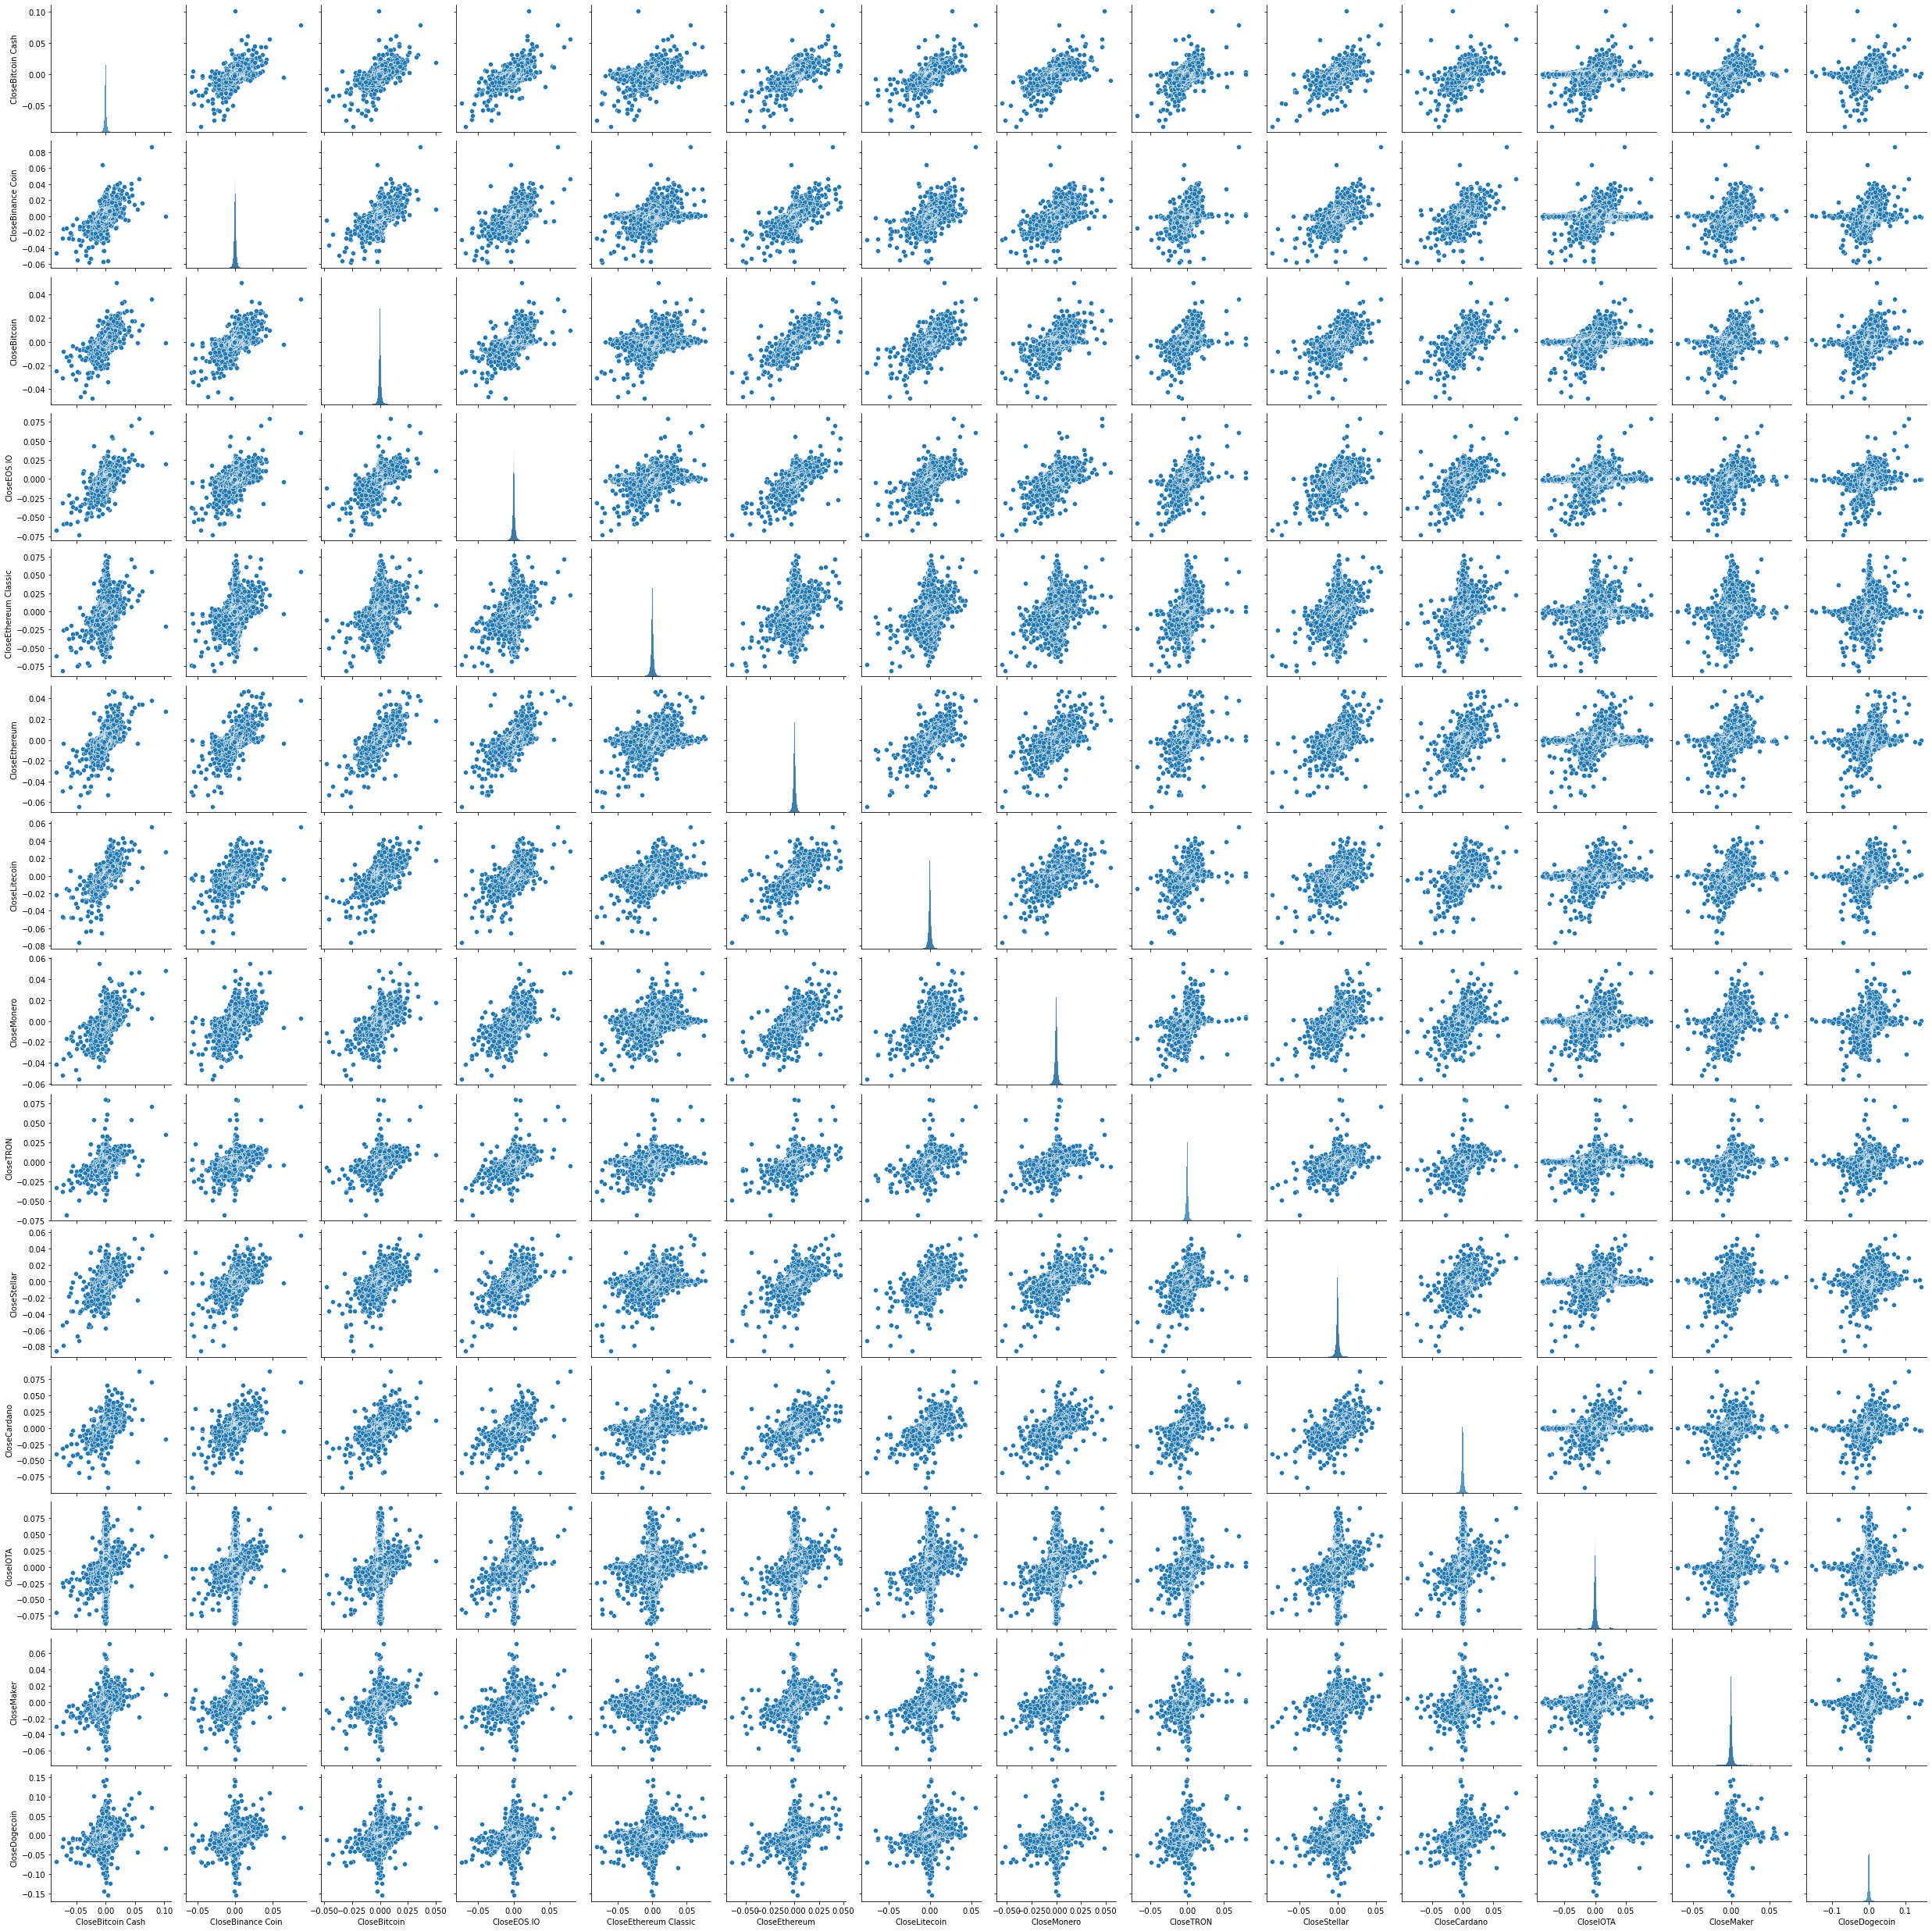

In [33]:
sns.pairplot(all_assets_2021)

From the correlation of logreturns it seems that there are some coins that strongly correlated.
Thus, we have the hypothesis that we could find 1 feature which consist of linear combination of log returns of all assets.
We use PCA to find the vector with the highest variance to project on it in case the ratio of var explainability is high

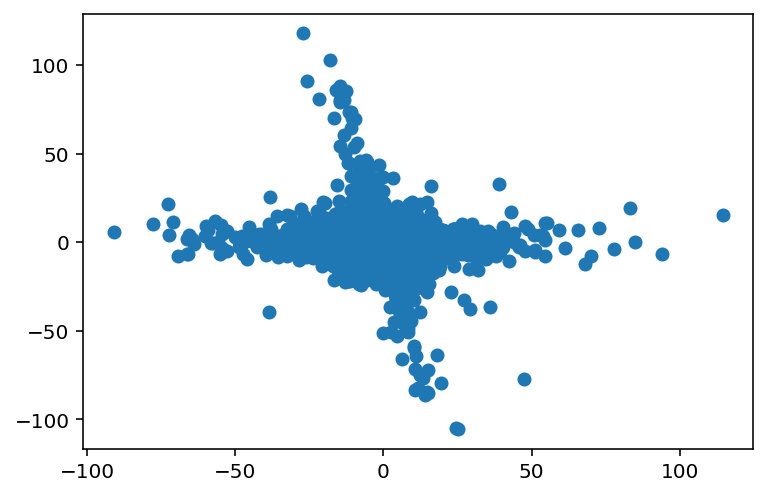

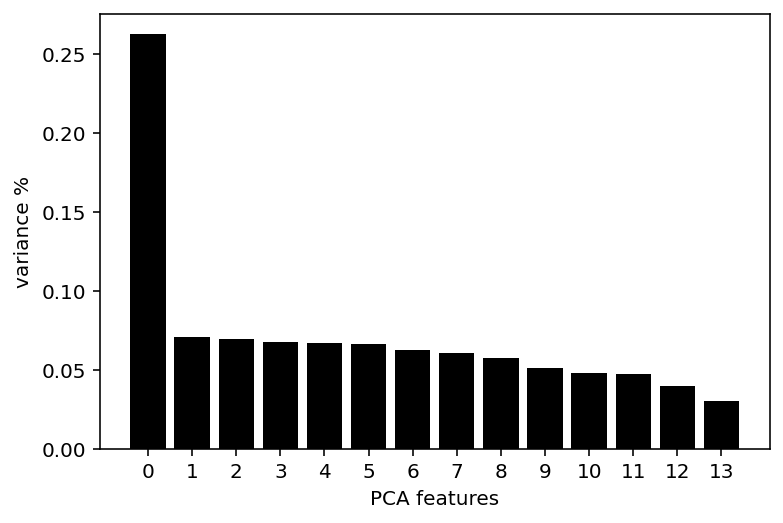

In [34]:
# Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%config InlineBackend.figure_format='retina'
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )


def vis_pca(all_assets):
    #as the range of diff coins is high we need to normalise it
    X_std = StandardScaler().fit_transform(all_assets.fillna(0))
    pca = PCA()
    X_std_pca = pca.fit_transform(X_std)
    plot = plt.scatter(X_std_pca[:,0], X_std_pca[:,1])
    #plt.legend(handles=plot.legend_elements()[0])
    plt.show()

    # Plot the explained variances
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    plt.show()
vis_pca(all_assets)

Fig shows that the first one component explains 25% of the variance in our data which doesn't seem promissing.


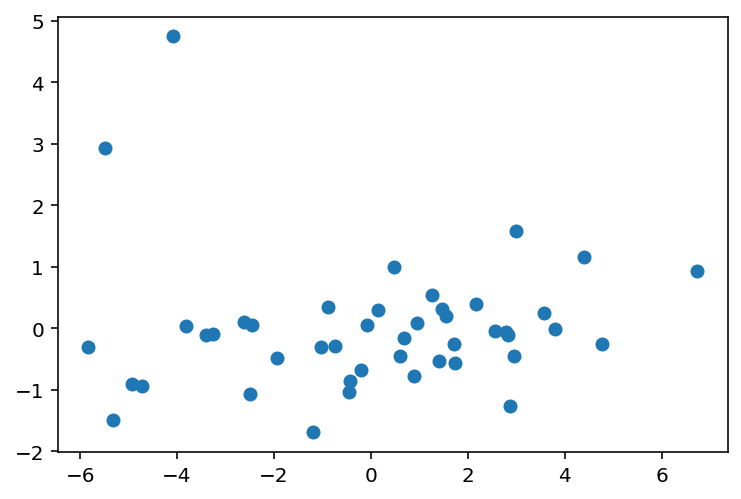

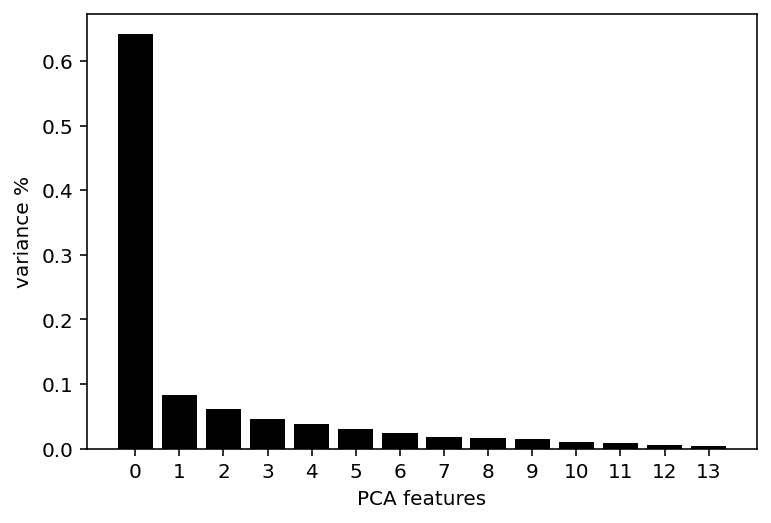

In [35]:
#for montly data
vis_pca(all_assets.resample('M').mean())

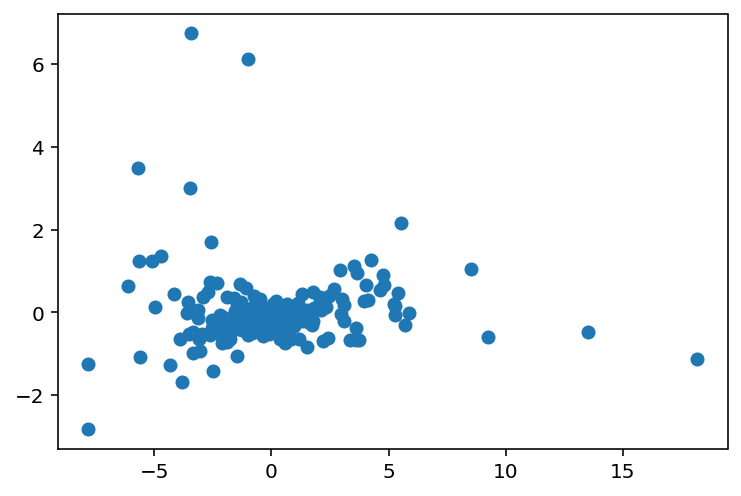

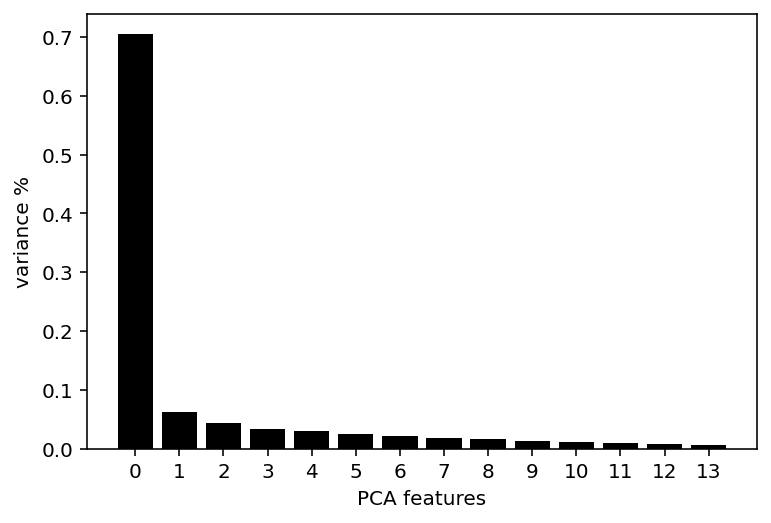

In [36]:
#for weekly data

vis_pca(all_assets.resample('W').mean())

Here could be used few components (e.g. that explains 90% to predict)

# BTC Seasonal Decomposition


BTC Seasonal Decomposition of monthly data


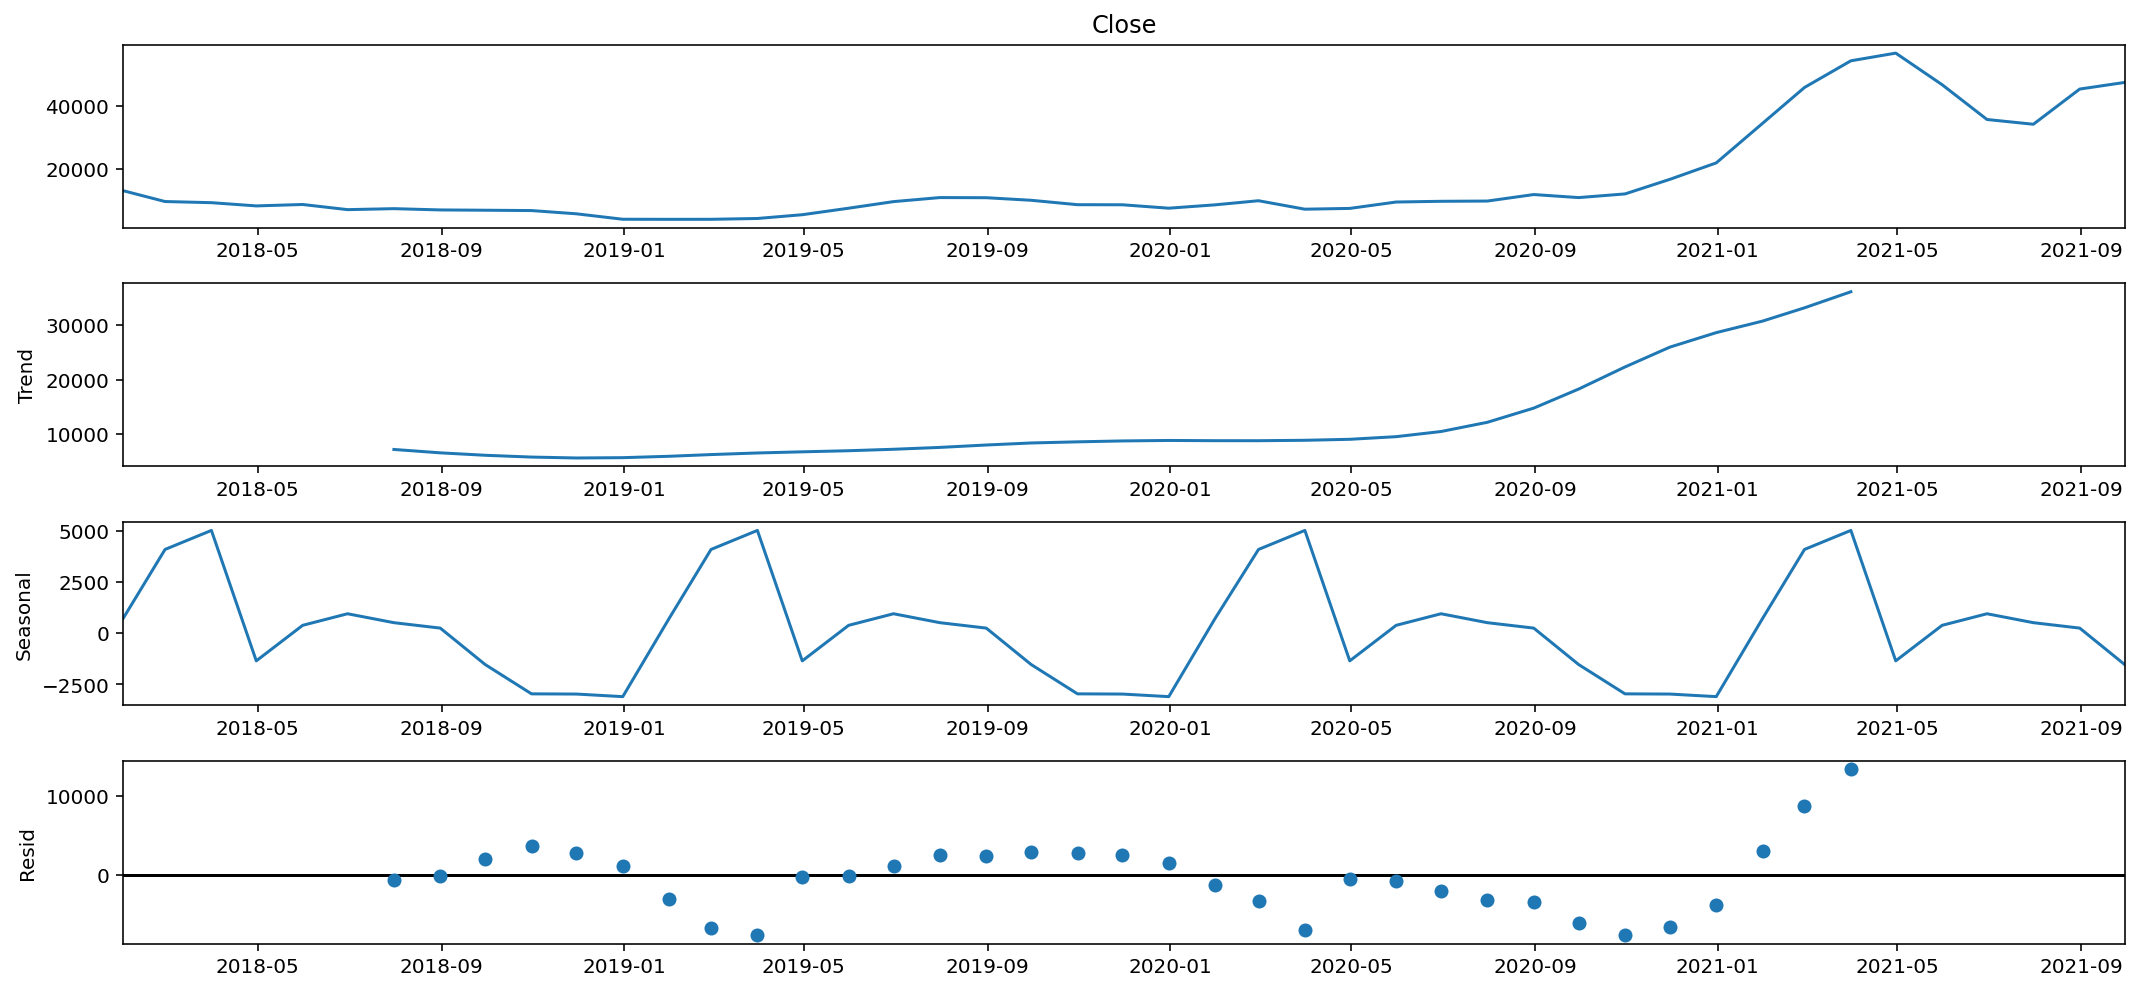

In [50]:
#freq https://stackoverflow.com/questions/17001389/pandas-resample-documentation
#explanation https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
plt.rcParams["figure.figsize"]=(15,7)

def season_df(data, label, a):
    df=data.resample(a).mean().dropna()
    seasonal_decompose(df.Close).plot()
    print(label)
    return plt.show()

season_df(data=btc, label="BTC Seasonal Decomposition of monthly data",a ="M")


BTC Seasonal Decomposition of daily data


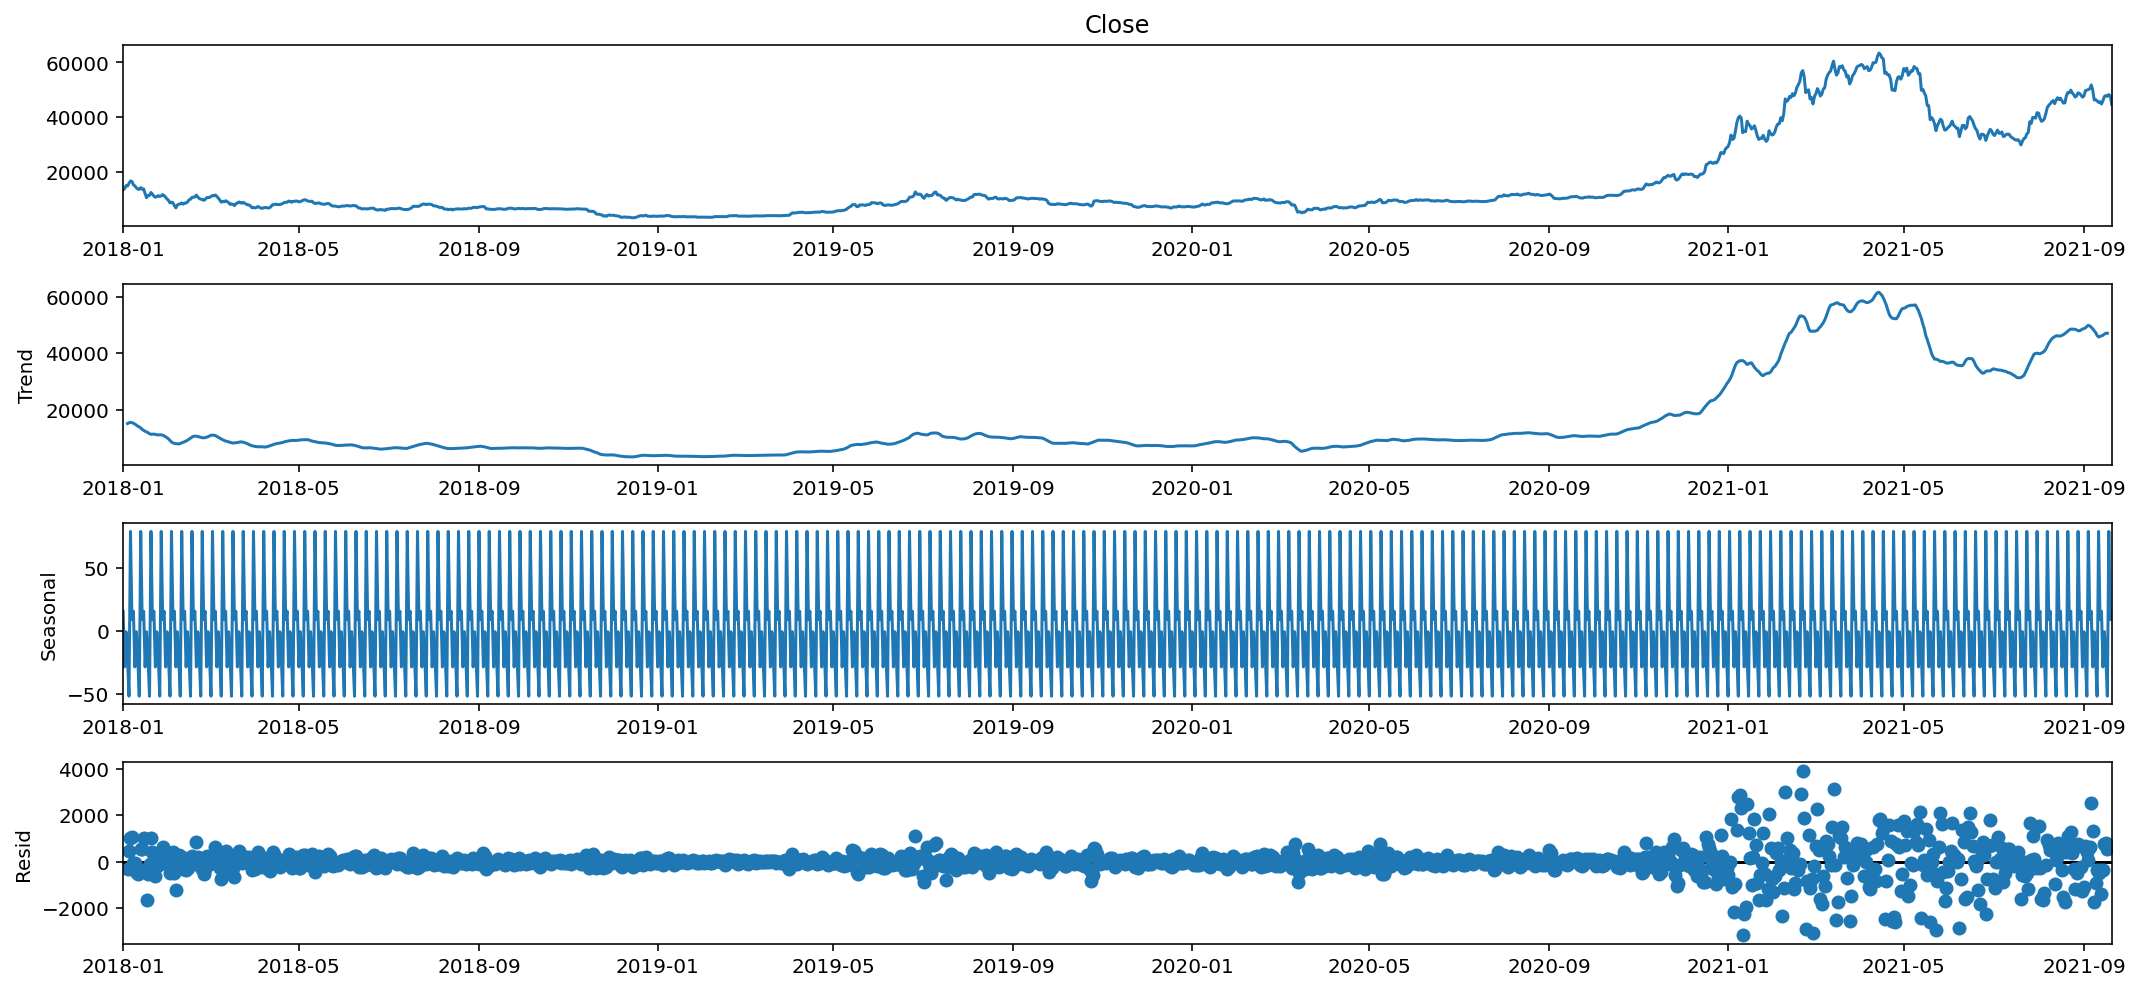

In [38]:
season_df(data=btc, label="BTC Seasonal Decomposition of daily data",a ="D")



